In [51]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, push_notebook
from bokeh.models import HoverTool, CustomJS, Slider, ColumnDataSource
from bokeh.layouts import row, column, gridplot
import trackpy as tp
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import label

output_notebook()
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(50, 50))
mpl.rc('image', cmap='gray')
mpl.rc('xtick', labelsize=32)
mpl.rc('ytick', labelsize=32)
mpl.rcParams['font.size'] = 42

Loading BokehJS ...

In [116]:
file_dir = 'C:\\Users\\aquiles\\Data\\2018-07-10\\run2'
filename = 'data.h5'
with h5py.File(os.path.join(file_dir, filename)) as file:
    data = file['Basler data'][:,:,:]
frames = np.linspace(1, data.shape[0], data.shape[0])

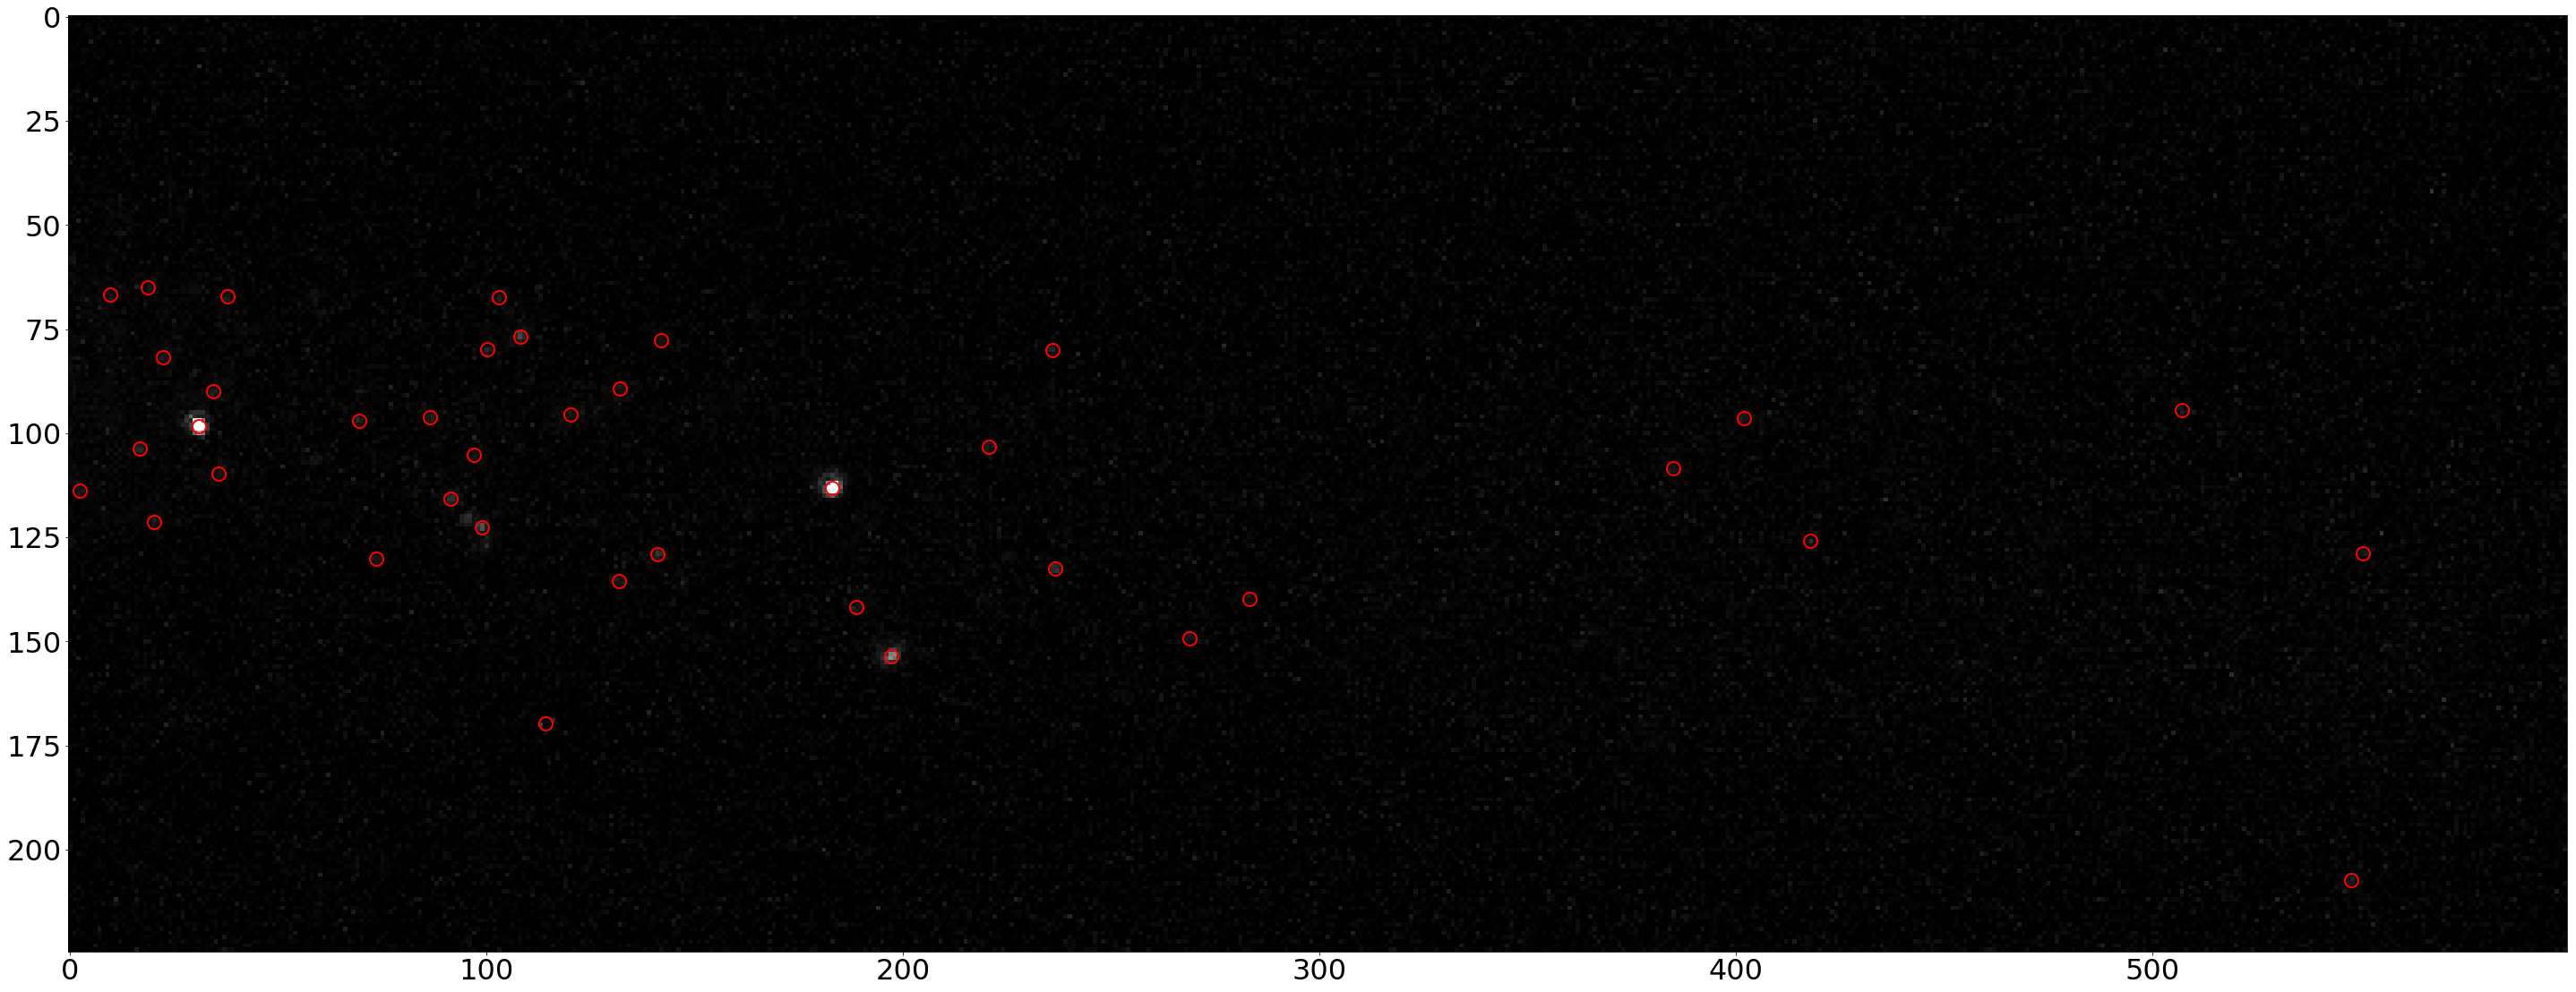

In [117]:
f = tp.locate(data[0, :,:], 7, minmass=800)
plt.figure()  # make a new figure
tp.annotate(f, data[0, : ,:]);

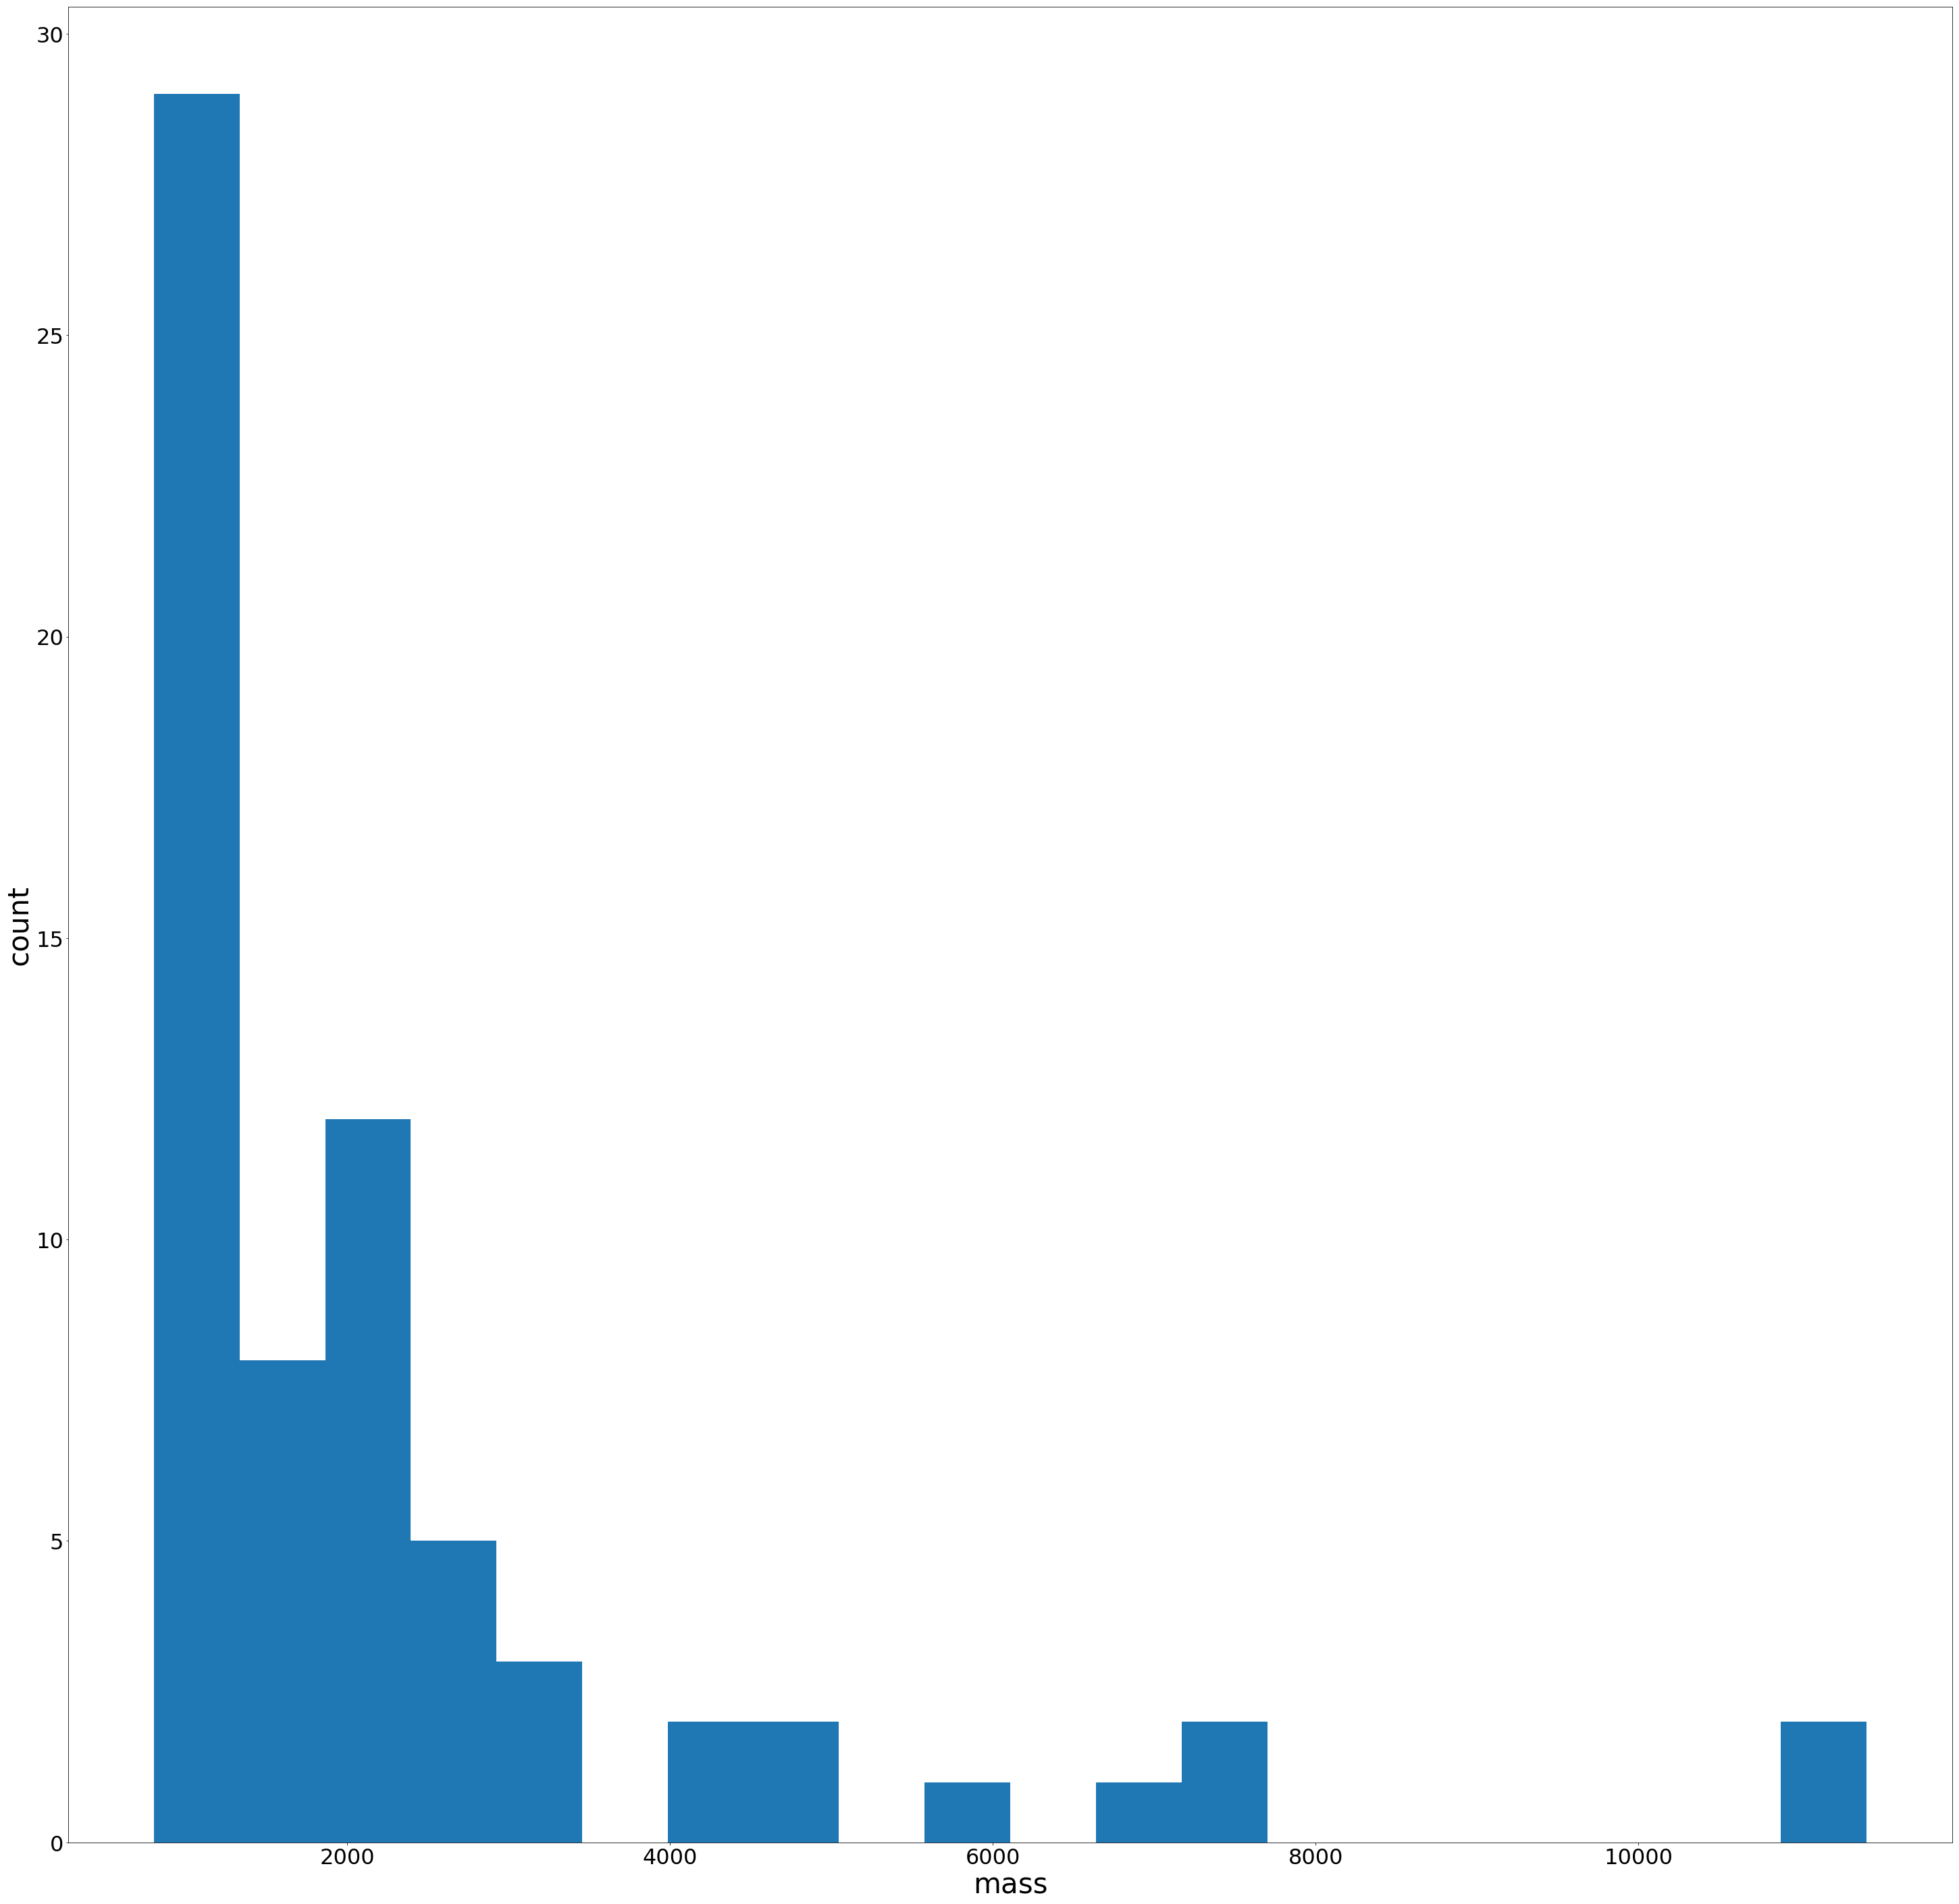

In [102]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [103]:
particles = tp.batch(data[:], 7, minmass=800);

Frame 999: 83 features


In [104]:
tracks = tp.link_df(particles, 5, memory=3)

Frame 999: 83 trajectories present.


In [105]:
filtered_tracks = tp.filter_stubs(tracks, 50)

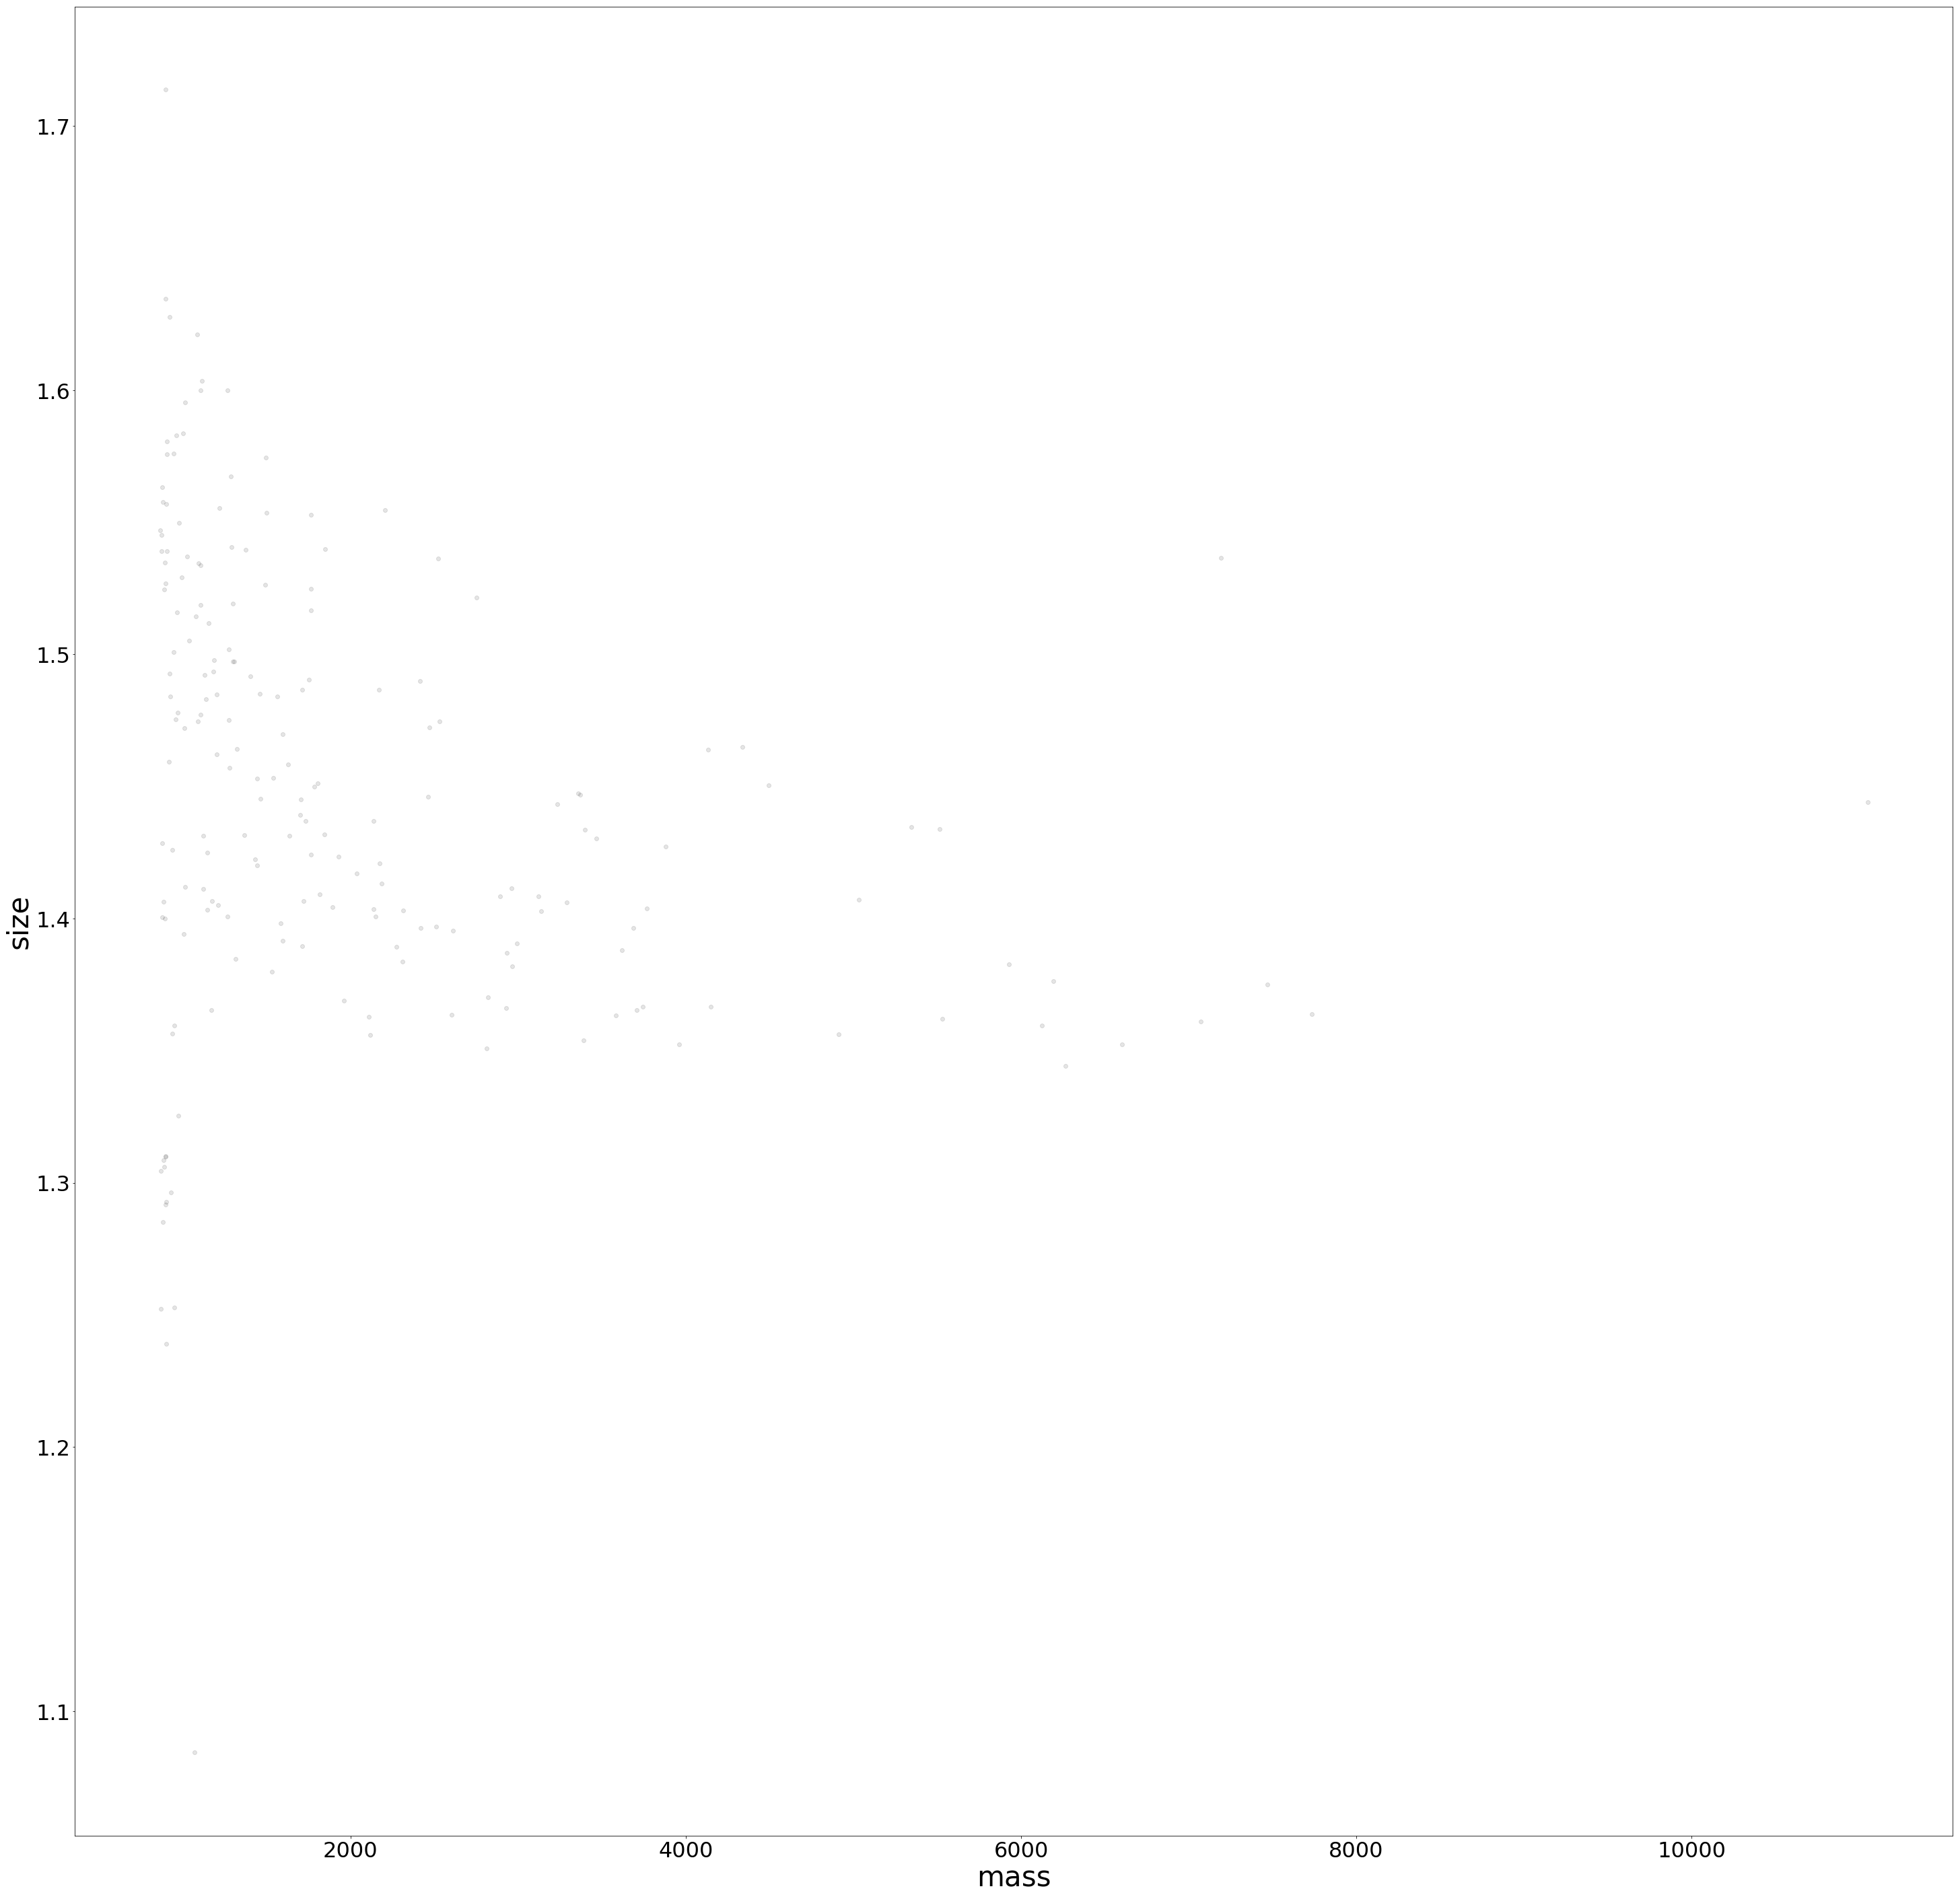

In [106]:
plt.figure()
tp.mass_size(filtered_tracks.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [107]:
drift = tp.compute_drift(filtered_tracks)

C:\ProgramData\Anaconda3\lib\site-packages\trackpy\utils.py:313: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  return df.sort_values(*args, by=by, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\trackpy\motion.py:289: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  dx = f_diff.loc[mask, pos_columns + ['frame']].groupby('frame').mean()


<Figure size 3600x3600 with 0 Axes>

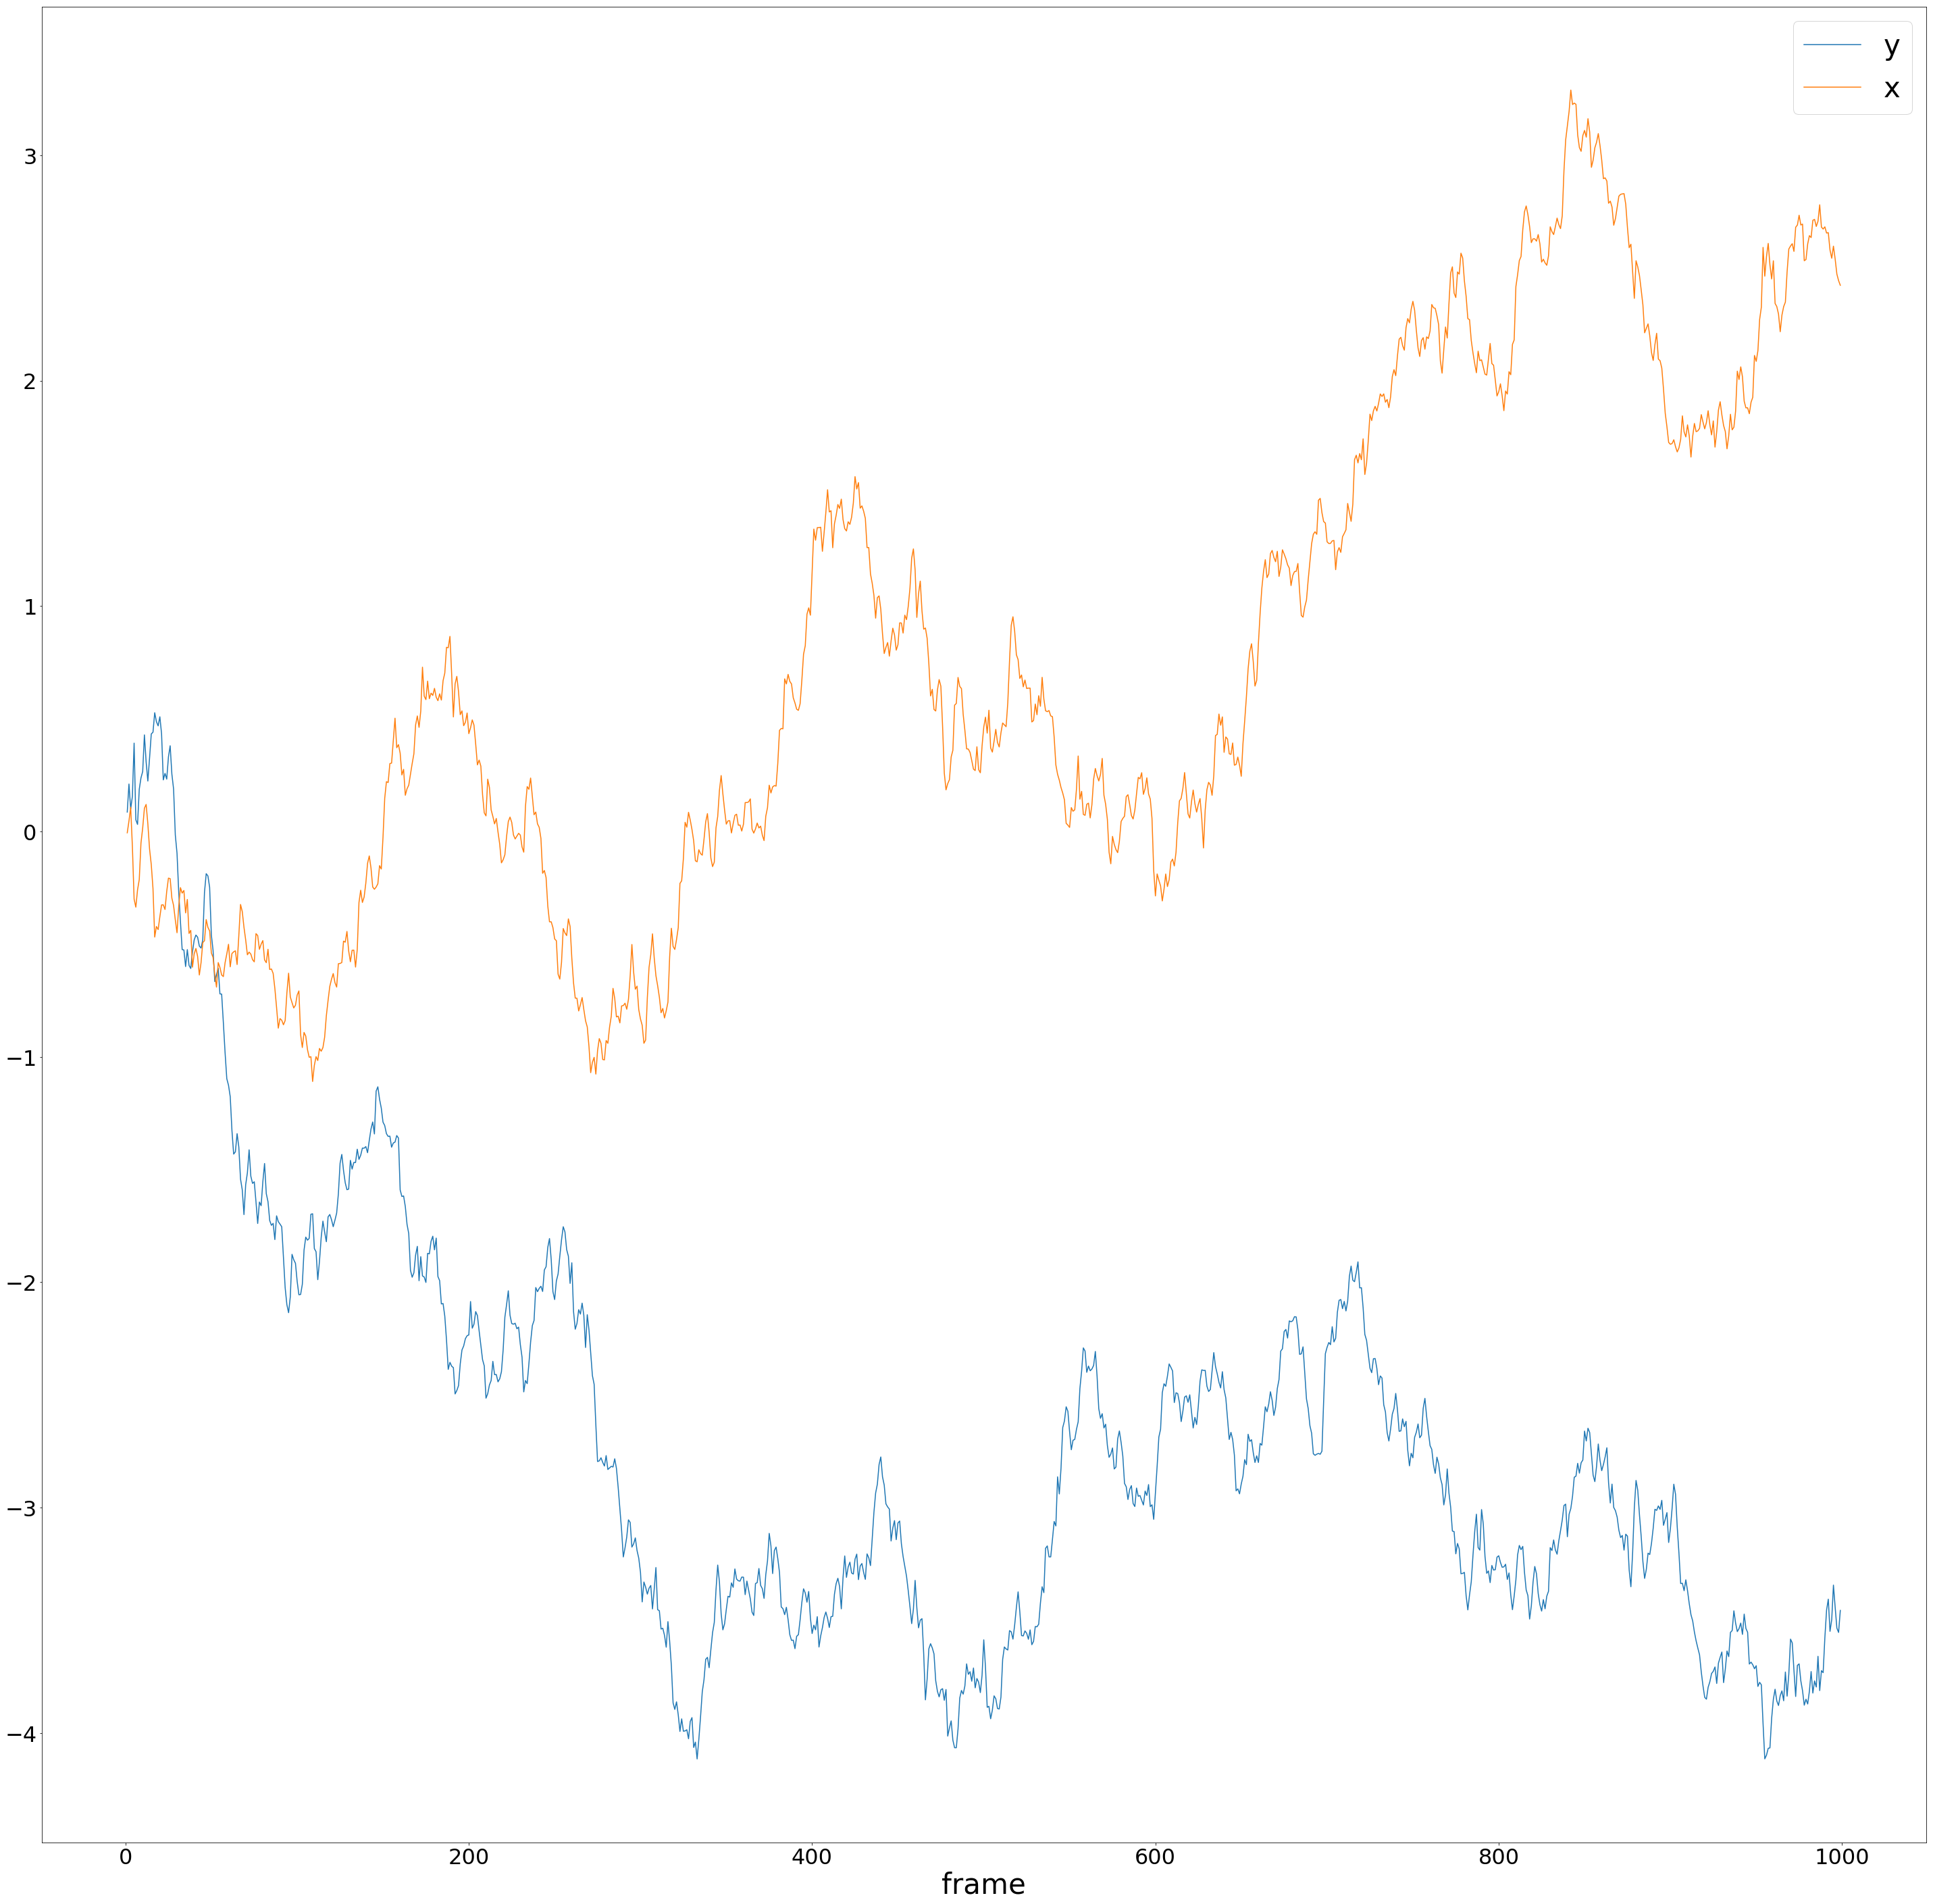

In [108]:
plt.figure()
drift.plot();

In [109]:
tracks_corrected = tp.subtract_drift(filtered_tracks.copy(), drift)

In [110]:
im = tp.imsd(tracks_corrected, 1, 55)

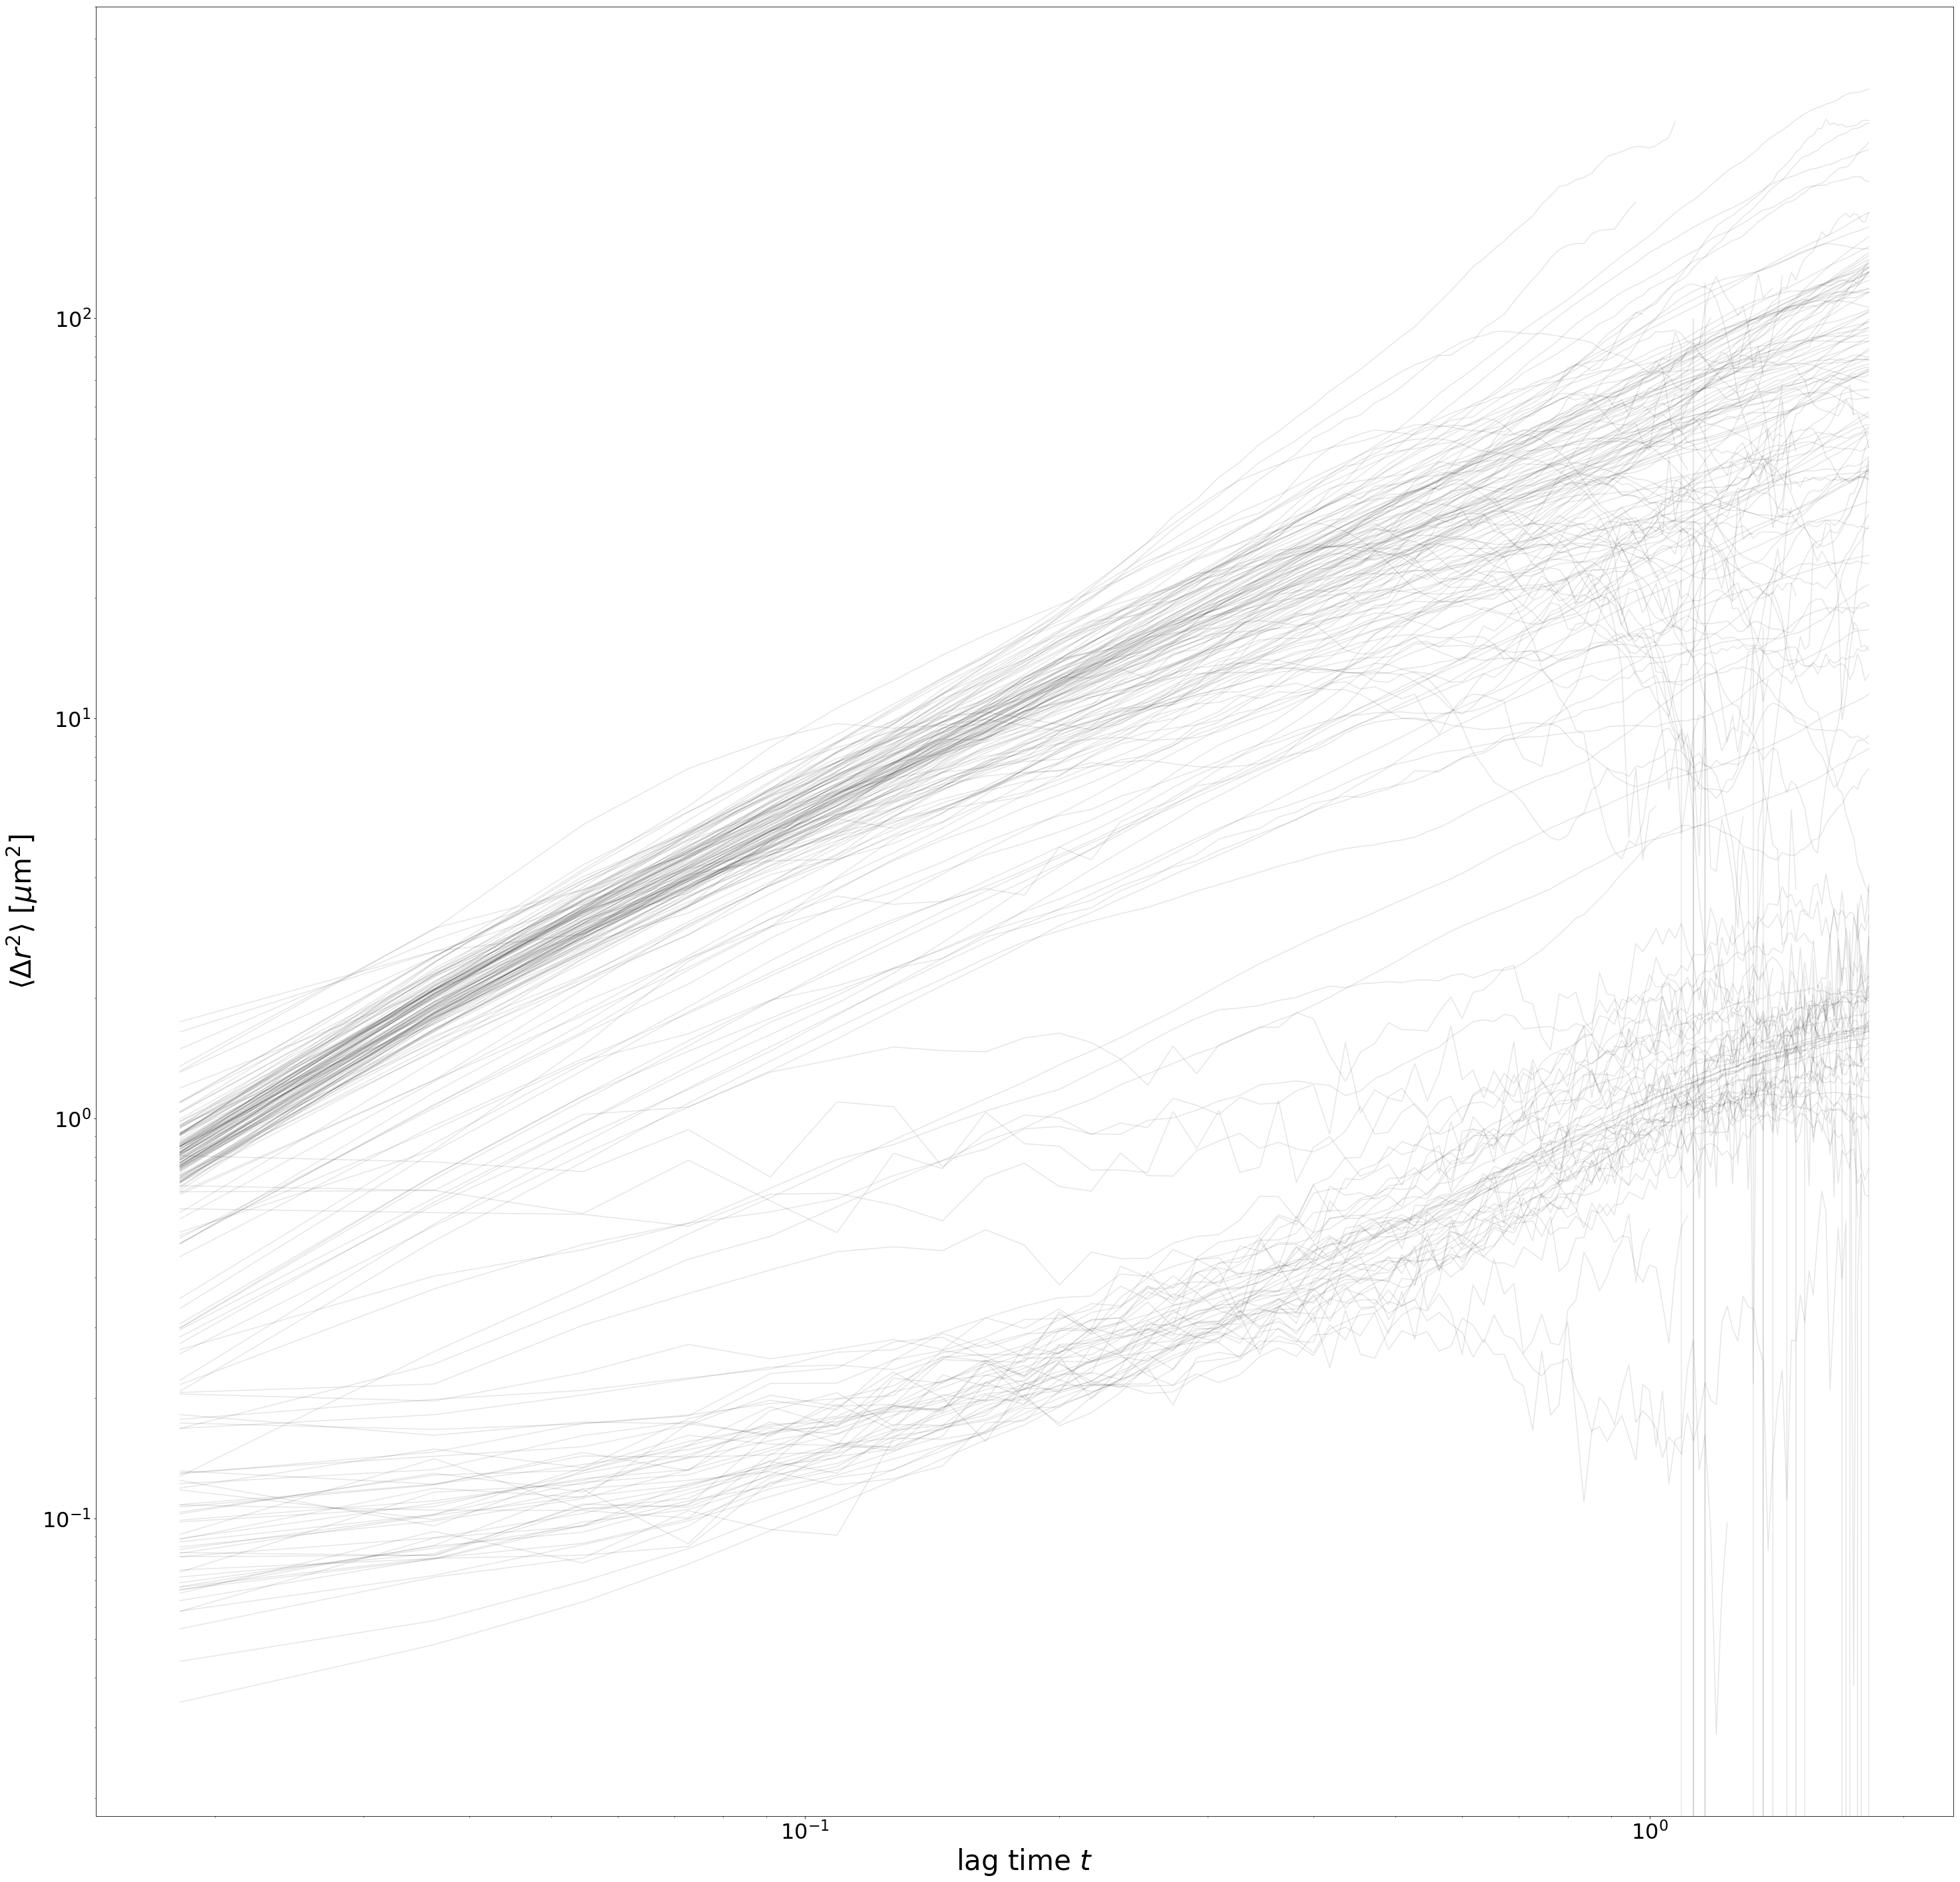

In [111]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [112]:
D = []
for pcle in im:
    try:
        msd = im[pcle]
        D.append(tp.utils.fit_powerlaw(msd, plot=False))
    except ValueError:
        continue

C:\ProgramData\Anaconda3\lib\site-packages\trackpy\utils.py:73: RuntimeWarning: divide by zero encountered in log
  stats.linregress(np.log(x), np.log(y))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3103: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [113]:
dif_coef_1 = []
dif_coef_2 = []
for d in D:
    dif_coef_1.append(float(d['n']))
    dif_coef_2.append(float(d['A']))
dif_coef_1 = np.array(dif_coef_1)
dif_coef_1 = dif_coef_1[~np.isnan(dif_coef_1)]
dif_coef_2 = np.array(dif_coef_2)
dif_coef_2 = dif_coef_2[~np.isnan(dif_coef_2)]

(array([ 3.,  5.,  7., 10., 33., 25., 32., 15.,  6.,  5.]),
 array([0.23890613, 0.35758704, 0.47626796, 0.59494887, 0.71362979,
        0.83231071, 0.95099162, 1.06967254, 1.18835346, 1.30703437,
        1.42571529]),
 <a list of 10 Patch objects>)

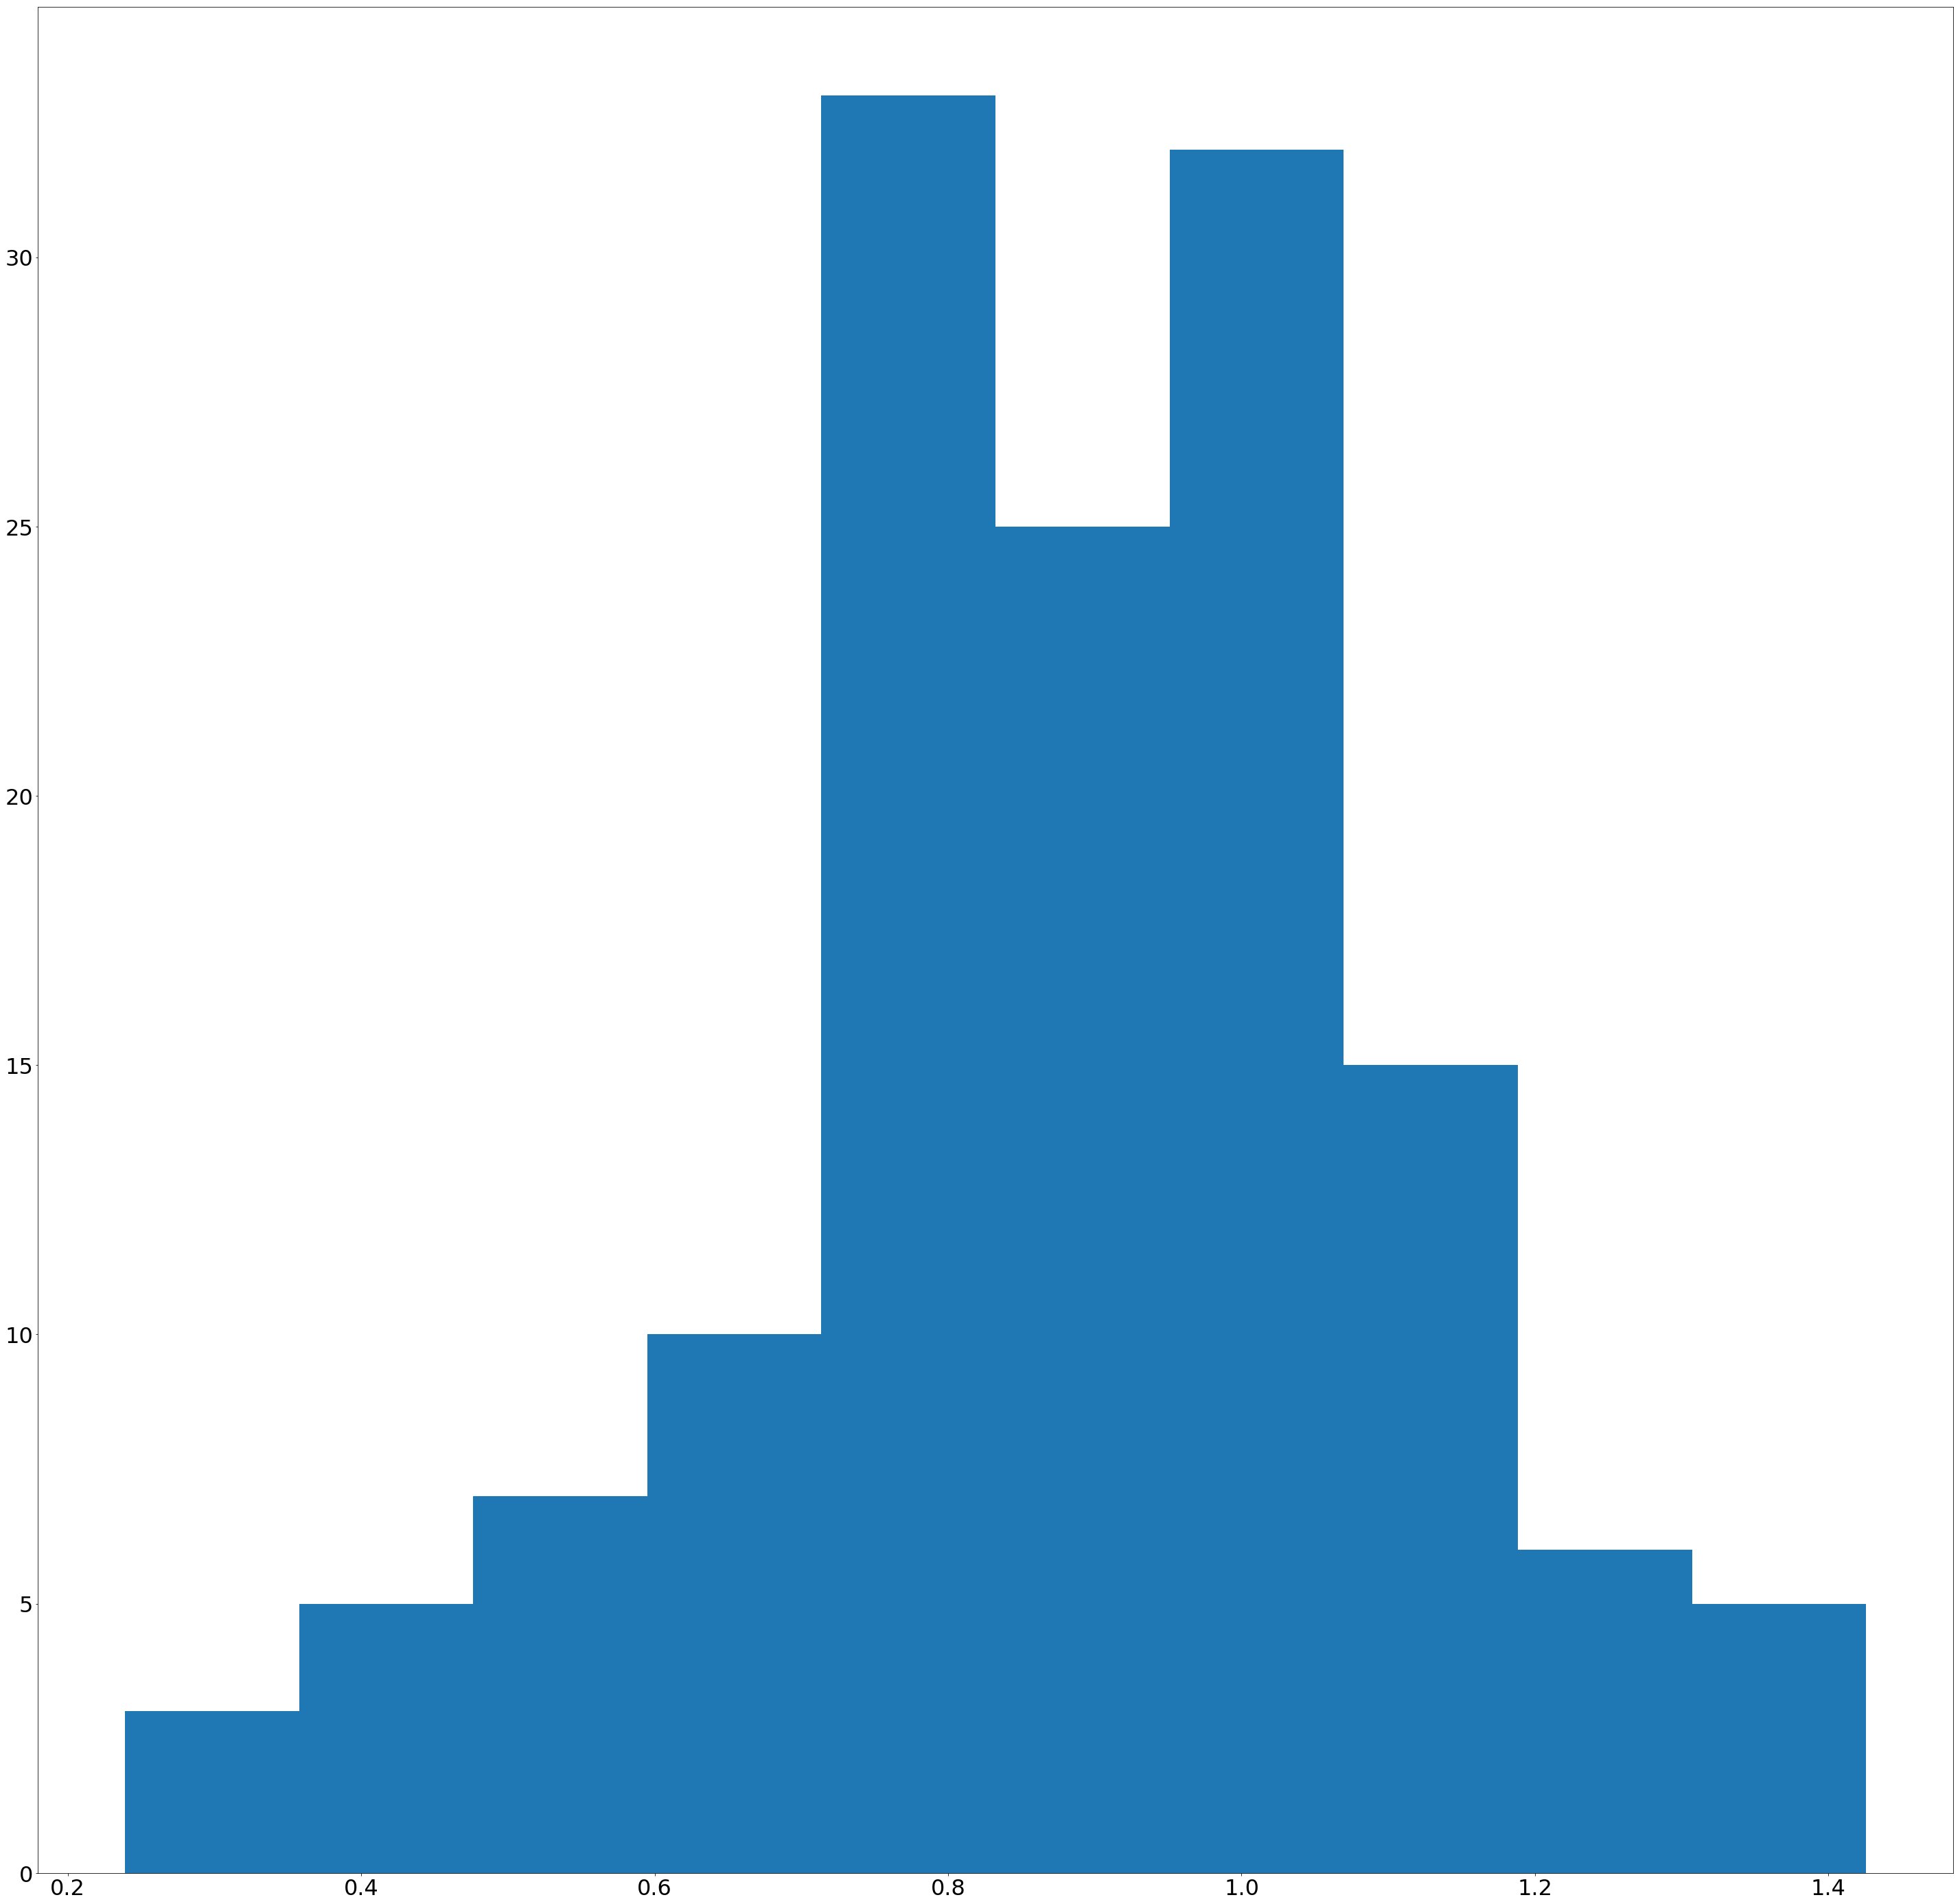

In [114]:
plt.hist(dif_coef_1)

(array([49., 16., 23., 26., 17.,  4.,  0.,  4.,  1.,  1.]),
 array([  0.70997544,  16.61604482,  32.52211421,  48.42818359,
         64.33425297,  80.24032235,  96.14639174, 112.05246112,
        127.9585305 , 143.86459988, 159.77066927]),
 <a list of 10 Patch objects>)

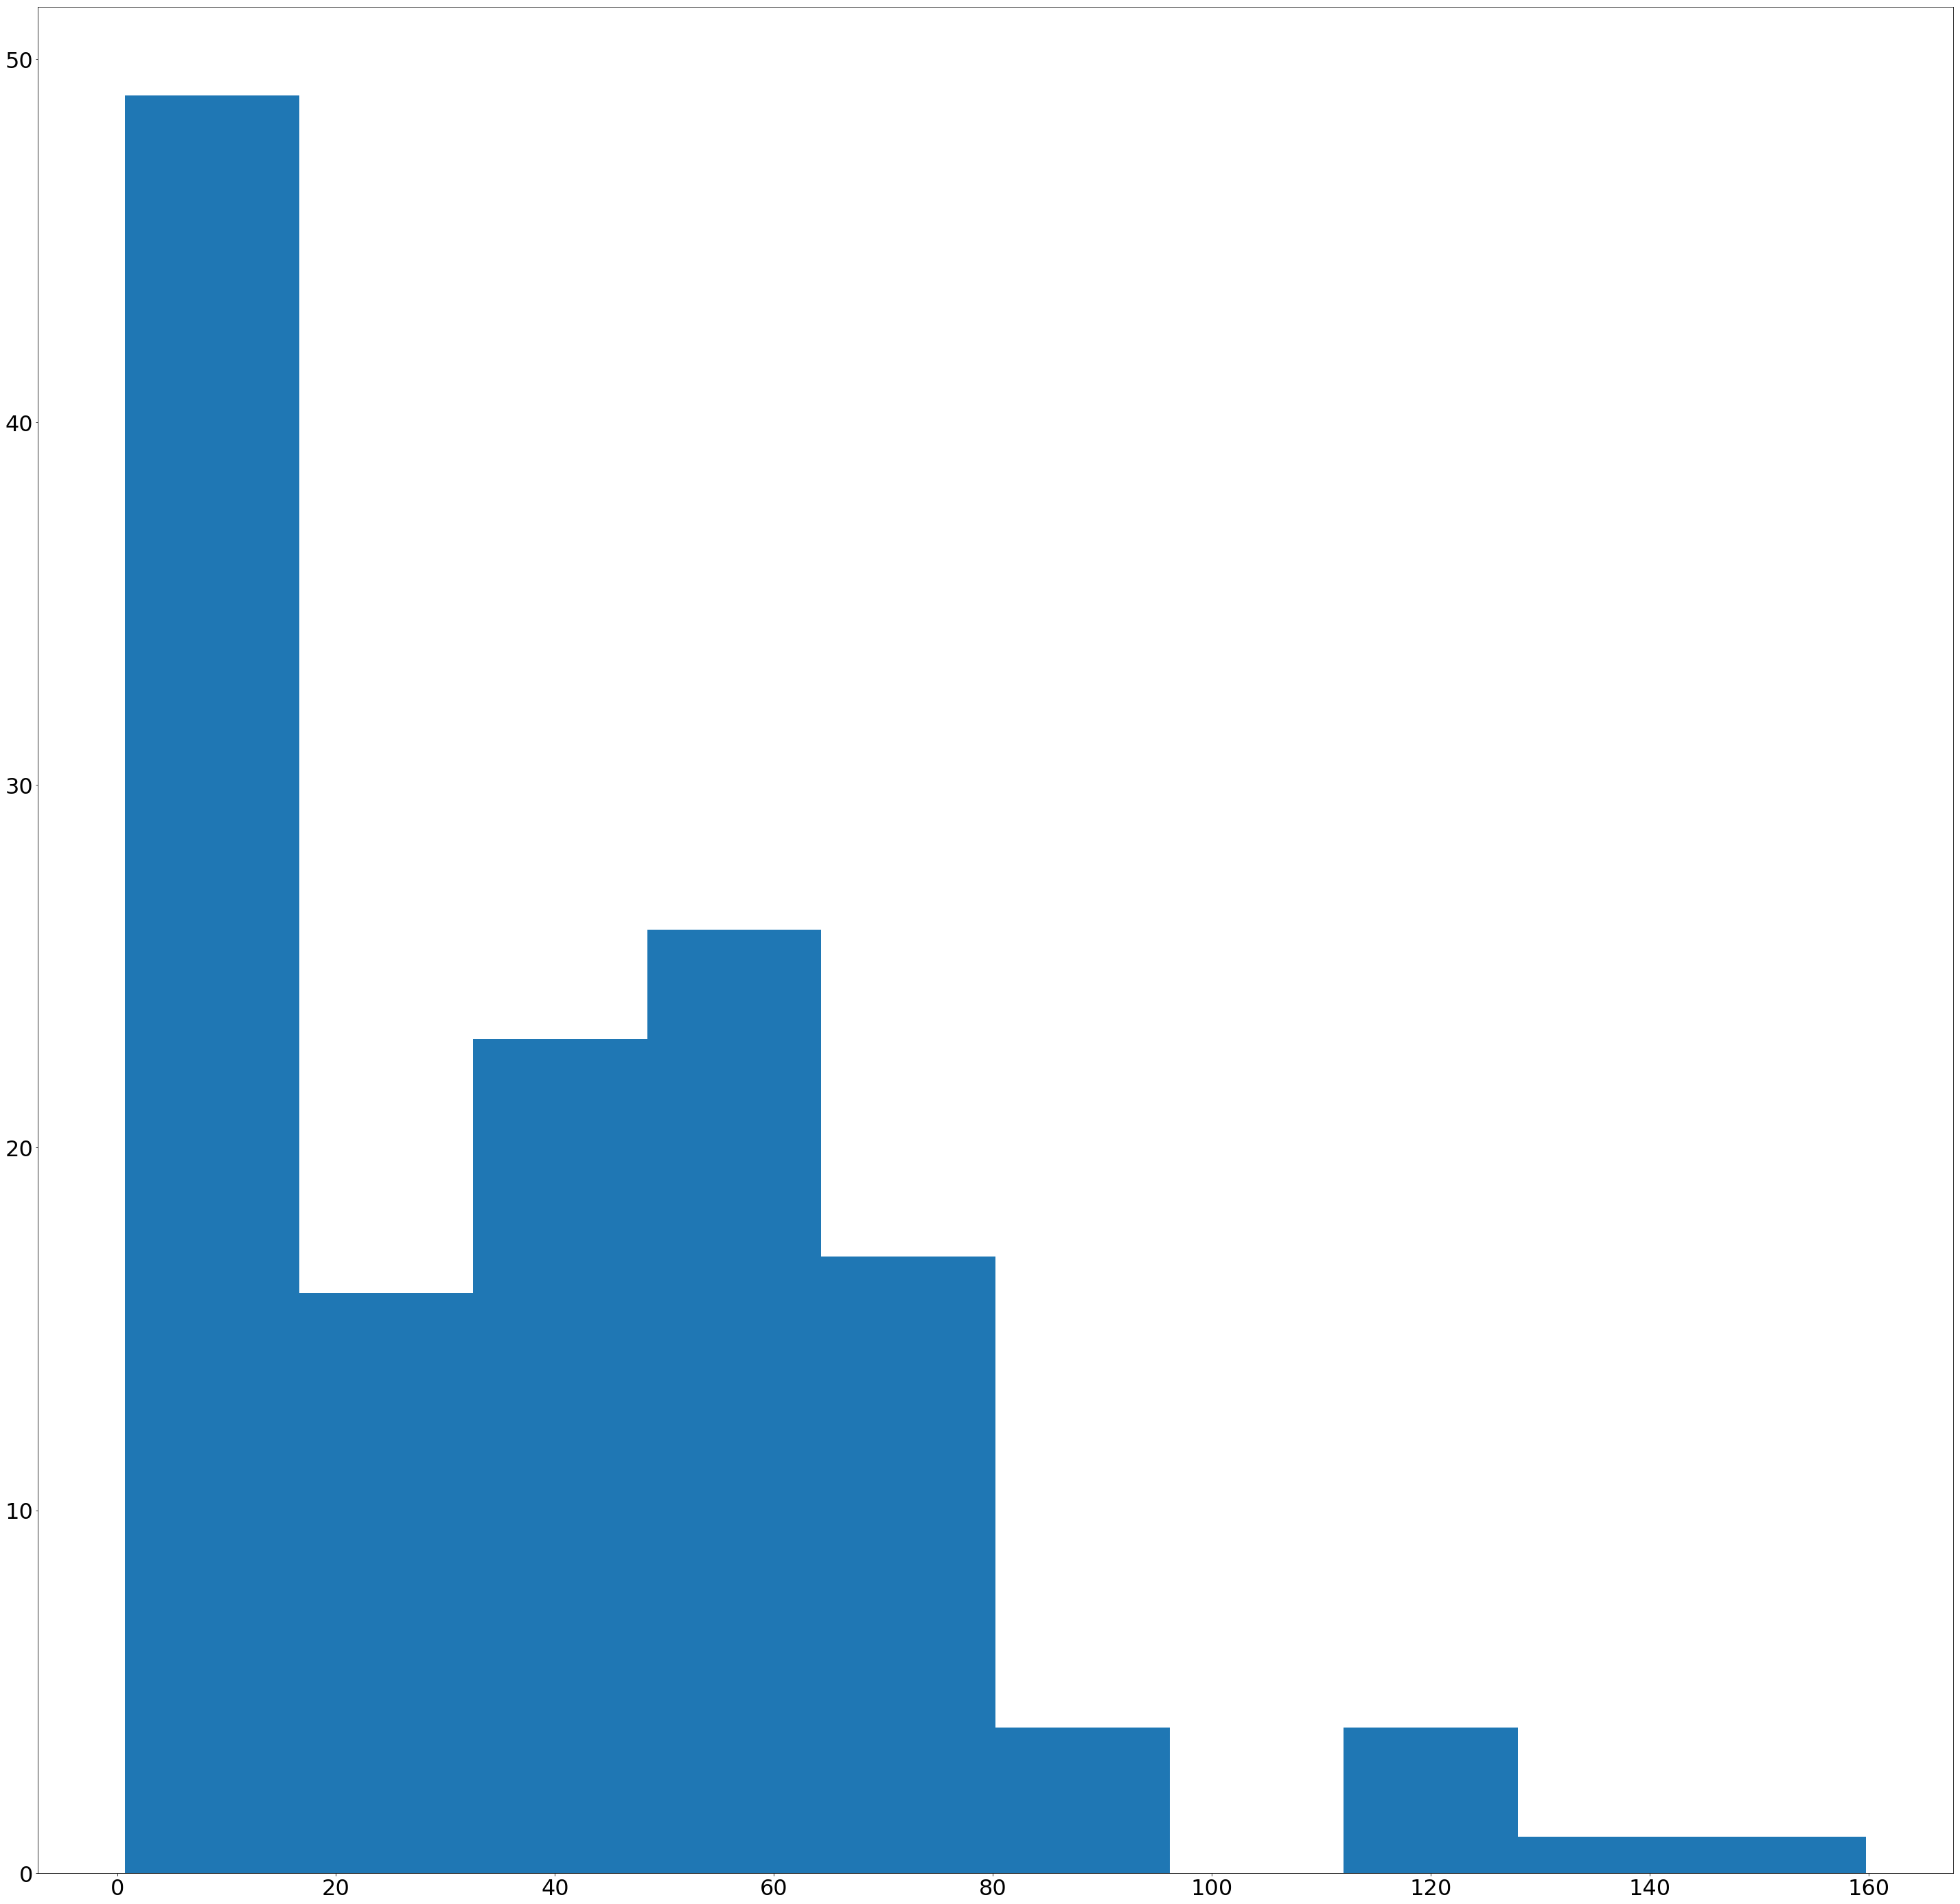

In [115]:
plt.hist(dif_coef_2)